In [1]:
import warnings

import rasterio
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import matplotlib
from figures import pltconfig # varibles arent imported, this just sets plt.rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import *
from shapely.errors import ShapelyDeprecationWarning

from scrollstats import RASTER_PATHS, BendDataset, calculate_ridge_metrics

In [2]:
plt.rcParams["font.family"]

['Arial']

## Get Data

In [3]:
bend_id = "LBR_025"
bend_ds = BendDataset(bend_id)
transects = bend_ds.get_transects(proj=True)
ridges = bend_ds.get_ridges(proj=True)
packets= bend_ds.get_packets(proj=True)

dem = rasterio.open(RASTER_PATHS[bend_id]["dem"])
bin_raster = rasterio.open(RASTER_PATHS[bend_id]["bin"])


In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ShapelyDeprecationWarning)
    rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)

itx = itx.loc[bend_id]

Started BDE
Started TDE for t_009
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_010
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_011
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_012
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_013
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_014
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_015
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_016
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_017
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RD

In [5]:
itx.head()

start_distances  transect_position  metric_confidence  \
transect_id ridge_id                                                          
t_009       r_002          185.679231                  4                  4   
            r_003          247.186196                  5                  4   
            r_007          334.035335                  6                  4   
            r_018          114.298928                  1                  1   
            r_019            0.000000                  0                  1   

                                              relative_vertex_distances  \
transect_id ridge_id                                                      
t_009       r_002     [0.4251412010392586, 0.5659708704817383, 0.764...   
            r_003     [0.5659708704817383, 0.764825353200405, 0.8918...   
            r_007     [0.764825353200405, 0.8918286694627616, 1.0000...   
            r_018     [0.26170500119995826, 0.3078529440844938, 0.32...   
            r_019        [0.0, 0.26170500119995826, 0.3078529440844938]   

                       vertex_indices  \
transect_id ridge_id                    
t_009       r_002     [185, 247, 333]   
            r_003     [247, 333, 389]   
            r_007     [333, 389, 436]   
            r_018     [114, 134, 144]   
            r_019       [0, 114, 134]   

                                                             dem_signal  \
transect_id ridge_id                                                      
t_009       r_002     [67.69890594482422, 67.68925476074219, 67.6816...   
            r_003     [66.97003173828125, 66.94657897949219, 66.8770...   
            r_007     [66.9379653930664, 66.9395980834961, 67.164581...   
            r_018     [67.0978012084961, 67.08560180664062, 67.16011...   
            r_019     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                                   dem_signal_selection  \
transect_id ridge_id                                                      
t_009       r_002     [67.69890594482422, 67.68925476074219, 67.6816...   
            r_003     [66.97003173828125, 66.94657897949219, 66.8770...   
            r_007     [66.9379653930664, 66.9395980834961, 67.164581...   
            r_018     [67.0978012084961, 67.08560180664062, 67.16011...   
            r_019     [65.37324523925781, 65.60702514648438, 65.7352...   

                                                             bin_signal  \
transect_id ridge_id                                                      
t_009       r_002     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
            r_003     [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
            r_007     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
            r_018     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
            r_019     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                                              bool_mask  \
transect_id ridge_id                                                      
t_009       r_002     [True, True, True, True, True, True, True, Tru...   
            r_003     [True, True, True, True, True, False, False, F...   
            r_007     [True, True, True, True, True, True, True, Tru...   
            r_018     [True, True, True, True, True, True, True, Tru...   
            r_019     [True, True, True, True, True, True, True, Tru...   

                      pre_mig_dist  ...  pre_mig_time  post_mig_time  \
transect_id ridge_id                ...                                
t_009       r_002        86.849140  ...           NaN            NaN   
            r_003        55.468343  ...           NaN            NaN   
            r_007        47.243526  ...           NaN            NaN   
            r_018         9.490952  ...           NaN            NaN   
            r_019        20.154985  ...           NaN            NaN   

                      pre_mig_rate  post_mig_

# Plot with Histograms

In [6]:
def agg_by_x(itx, col, num_bins=20, agg_func="mean"):
    """Aggregate the values at each itx to a given number of columns."""

    # Get bounds of the itx dataframe
    minx, miny, maxx, maxy = itx.total_bounds

    # Get x coords of the bins
    bin_xcoords = np.linspace(minx, maxx, num_bins)

    # Create array of bounding boxes for x axis
    geoms = [box(x1, miny, x2, maxy) for x1, x2 in zip(bin_xcoords[:-1], bin_xcoords[1:])]

    xbins = gpd.GeoDataFrame({"geometry":geoms}, crs = itx.crs)
    agg_values = xbins.sjoin(itx)[col].groupby(level=0).agg(agg_func)

    # Join agg values back onto geometries
    xbin_agg = xbins.join(agg_values)
    
    return xbin_agg

In [7]:
def agg_by_y(itx, col, num_bins=20, agg_func="mean"):
    """Aggregate the values at each itx to a given number of columns."""

    # Get bounds of the itx dataframe
    minx, miny, maxx, maxy = itx.total_bounds

    # Get y coords of the bins
    bin_ycoords = np.linspace(miny, maxy, num_bins)

    # Create array of bounding boxes for y axis
    geoms = [box(minx, y1, maxx, y2) for y1, y2 in zip(bin_ycoords[:-1], bin_ycoords[1:])]

    ybins = gpd.GeoDataFrame({"geometry":geoms}, crs = itx.crs)
    agg_values = ybins.sjoin(itx)[col].groupby(level=0).agg(agg_func)

    # Join agg values back onto geometries
    ybin_agg = ybins.join(agg_values)
    
    return ybin_agg

In [8]:
# fig = plt.figure(figsize=(5,4))
# gs = GridSpec(4,5, figure=fig)

# # Main Itx Plot
# vmin = 0
# vmax = itx["ridge_amp"].max()

# ## Create Colorbar
# ax1 = fig.add_subplot(gs[1:, :4])
# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("left", size="5%", pad=0.1, aspect=2)

# ## Plot itx and ridges
# itx.plot(ax=ax1, column="ridge_amp", markersize="ridge_width", vmin=vmin, vmax=vmax, legend=True, cax=cax)
# ridges.plot(ax=ax1, color="k", ls="--", lw=0.5, zorder=0)

# min_max = [vmin, vmax]
# cax.set_yticks(min_max, labels = np.round(min_max, 1))
# cax.set_ylabel("Amplitude [m]")

# cax.yaxis.set_ticks_position('left')
# cax.yaxis.set_label_position('left')

# ax1.set_axis_off()

# # Top hist
# ax2 = fig.add_subplot(gs[0, :4])
# xbins = agg_by_x(itx, "ridge_amp", 20, "mean")
# xbins["ridge_amp"].T.plot(kind="bar", ax=ax2, width=0.8, color="mediumseagreen")
# ax2.set_xticks([])
# ax2.set_yticklabels(["0m", "2m"])
# ax2.set_xlim(-3.5, 21.5)
# ax2.spines["top"].set_color(None)
# ax2.spines["right"].set_color(None)


# # Right Hist
# ax3 = fig.add_subplot(gs[1:, 4])
# ybins = agg_by_y(itx, "ridge_amp", 20, "mean")
# ybins["ridge_amp"].plot(kind="barh", ax=ax3, width=0.8, color="mediumseagreen")
# ax3.set_yticks([])
# ax3.set_xticklabels(["0m", "2m"])
# ax3.set_ylim(-4.5, 24.8)
# ax3.spines["top"].set_color(None)
# ax3.spines["right"].set_color(None)

# # Top box
# ax4 = fig.add_subplot(gs[0, -1])
# ax4.text(0.5, 0.5, "Mean\nAmplitude", horizontalalignment="center", verticalalignment="center")
# ax4.set_xticks([])
# ax4.set_yticks([])
# ax4.set_axis_off()

# # Add x and x bins as a grid
# xbins.boundary.plot(ax=ax1, color='grey', lw=0.2, alpha=0.5, zorder=0)
# ybins.boundary.plot(ax=ax1, color='grey', lw=0.2, alpha=0.5, zorder=0)

# # plt.tight_layout()
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
# # plt.savefig("/Users/avan/FLUD/BrazosScrolls/figures/RidgeAmplitudeJointPlot_colorbar.png", dpi=300)


## Create box plots of ridge metrics

In [9]:
ridge_metrics = itx[["ridge_amp", "ridge_width", "pre_mig_dist"]]
ridge_metrics.columns = ridge_metrics.columns.rename("metrics")

itx_w_packets = itx.sjoin(packets.drop("bend_id", axis=1))
itx_w_packets = itx_w_packets.reset_index().set_index(["transect_id", "ridge_id", "packet_id"])
ridge_metrics_w_packets = itx_w_packets[["ridge_amp", "ridge_width", "pre_mig_dist"]]
ridge_metrics_w_packets.columns = ridge_metrics_w_packets.columns.rename("metrics")

ridge_metrics

metrics               ridge_amp  ridge_width  pre_mig_dist
transect_id ridge_id                                      
t_009       r_002      0.778679         22.0     86.849140
            r_003      1.298214         18.0     55.468343
            r_007      1.585457         29.0     47.243526
            r_018      1.861023          NaN      9.490952
            r_019      3.155273          NaN     20.154985
...                         ...          ...           ...
t_047       r_012      0.662466         20.0     81.149474
            r_013      0.716354         13.0     39.219145
t_048       r_012      0.722620         12.0     65.307459
            r_013      1.100231         22.0     47.815527
t_049       r_013      0.430981         15.0     69.967953

[245 rows x 3 columns]

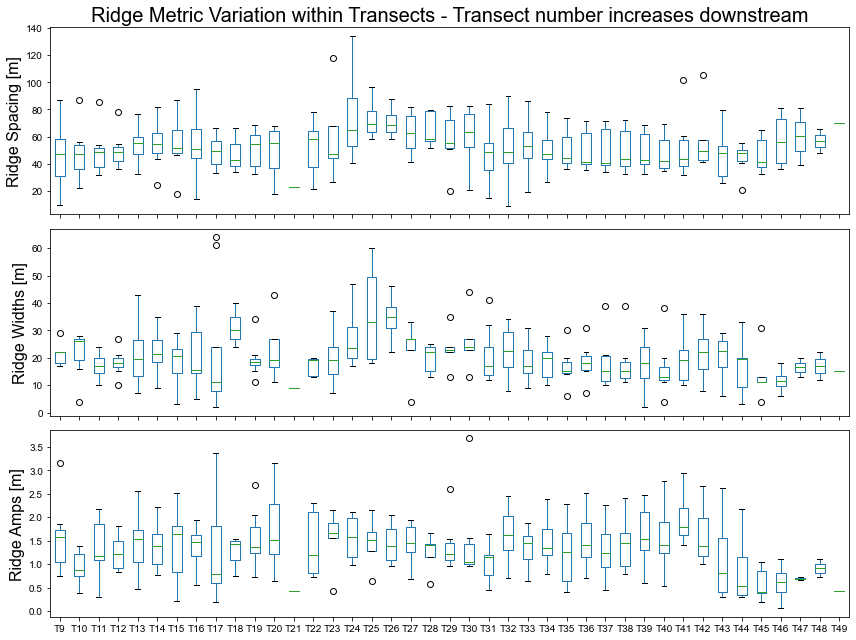

In [10]:
ridge_metrics_per_transect = ridge_metrics.unstack(level=0)

amps_per_transect = ridge_metrics_per_transect["ridge_amp"]
widths_per_transect = ridge_metrics_per_transect["ridge_width"]
spacing_per_transect = ridge_metrics_per_transect["pre_mig_dist"]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9))

ax1 = spacing_per_transect.boxplot(ax=ax1, grid=False)
ax2 = widths_per_transect.boxplot(ax=ax2, grid=False)
ax3 = amps_per_transect.boxplot(ax=ax3, grid=False)

# Set tick labels
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels(spacing_per_transect.columns.str.replace("t_0*", "T", regex=True))

# Set y labels
ax1.set_ylabel("Ridge Spacing [m]", size=16)
ax2.set_ylabel("Ridge Widths [m]", size=16)
ax3.set_ylabel("Ridge Amps [m]", size=16)

# ax1.plot([0, 36], [120,120], color="r")

ax1.set_title("Ridge Metric Variation within Transects - Transect number increases downstream", size=20, horizontalalignment="center")
plt.tight_layout()
# plt.savefig(f"RidgeMetrics_Boxplot_Transect_{bend_id}.png", dpi=300)


<AxesSubplot:xlabel='ridge_amp', ylabel='ridge_width'>

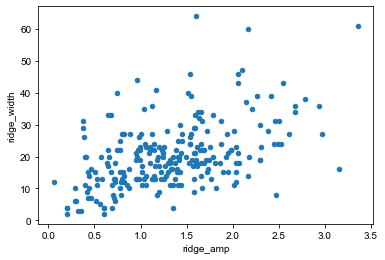

In [11]:
ridge_metrics.plot(x="ridge_amp", y="ridge_width", kind="scatter")

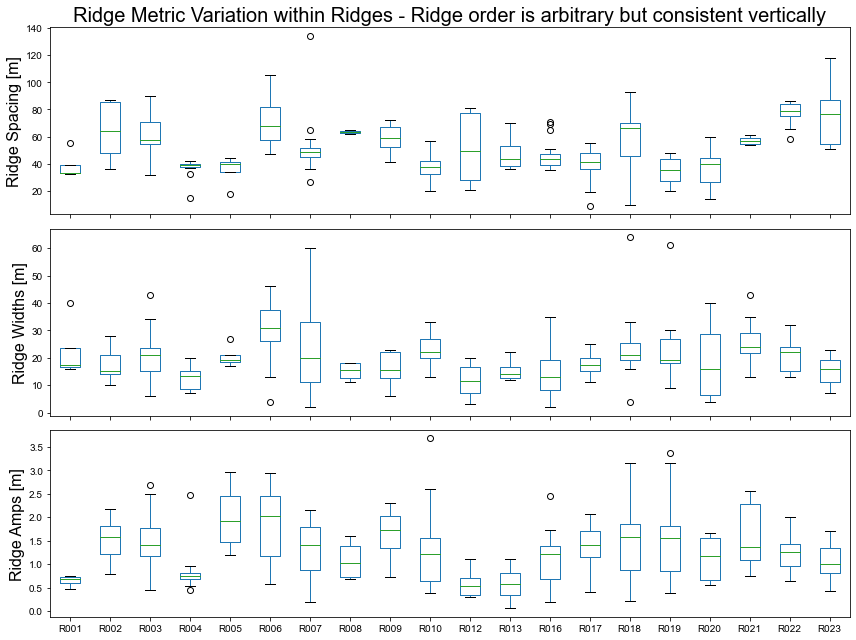

In [12]:
ridge_metrics_per_ridge = ridge_metrics.unstack()

amps_per_ridge = ridge_metrics_per_ridge["ridge_amp"]
widths_per_ridge = ridge_metrics_per_ridge["ridge_width"]
spacing_per_ridge = ridge_metrics_per_ridge["pre_mig_dist"]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9))

ax1 = spacing_per_ridge.boxplot(ax=ax1, grid=False)
ax2 = widths_per_ridge.boxplot(ax=ax2, grid=False)
ax3 = amps_per_ridge.boxplot(ax=ax3, grid=False)

# Set tick labels
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels(spacing_per_ridge.columns.str.replace("r_*", "R", regex=True))

# Set y labels
ax1.set_ylabel("Ridge Spacing [m]", size=16)
ax2.set_ylabel("Ridge Widths [m]", size=16)
ax3.set_ylabel("Ridge Amps [m]", size=16)

ax1.set_title("Ridge Metric Variation within Ridges - Ridge order is arbitrary but consistent vertically", size=20, horizontalalignment="center")
plt.tight_layout()
# plt.savefig(f"figures/RidgeMetrics_Boxplot_Ridge_{bend_id}.png", dpi=300)

# Plot metrics aggregated (and normalized) to the ridge, transect and packet scales


In [13]:
def normalize_vals(x):
    """Normalize the values within an array x between 0 and 1 """
    norm = (x - x.min())/(x.max()-x.min())
    return norm

In [14]:
def agg_and_norm_itx_metrics(itx, ridges, transects, packets, rs_variables, agg_stat="median"):
    
    norm_variable_col_names = [f"{variable}_norm" for variable in rs_variables]

    # Normalize itx values
    itx[norm_variable_col_names] = itx[rs_variables].apply(normalize_vals)

    # Aggregate to the ridge scale
    ridge_agg = itx.groupby(level=-1).agg(agg_stat)
    ridge_agg[norm_variable_col_names] = ridge_agg[rs_variables].apply(normalize_vals)
    ridge_agg = ridge_agg.join(ridges.set_index("ridge_id").geometry)

    # Aggregate to the transect scale
    trans_agg = itx.groupby(level=0).agg(agg_stat)
    trans_agg[norm_variable_col_names] = trans_agg[rs_variables].apply(normalize_vals)
    trans_agg = trans_agg.join(transects.set_index("transect_id").geometry)

    # Normalize within the packets
    # Spatial join packet id onto itx points
    itx_packets = itx.sjoin(packets.drop("bend_id", axis=1))
    itx_packets = itx_packets.reset_index().set_index(["packet_id", "transect_id", "ridge_id"])

    # Normalize amplitude and width within packet bounds
    packet_norm = pd.DataFrame(columns=norm_variable_col_names)
    packet_norm[norm_variable_col_names] = itx_packets[rs_variables].groupby(level=0).apply(normalize_vals)

    # Join back the geometry anc recast to GDF
    packet_norm = gpd.GeoDataFrame(packet_norm.join(itx_packets.geometry, how="left"))

    return itx, ridge_agg, trans_agg, packet_norm

In [15]:
itx, ridge_agg, trans_agg, packet_norm = agg_and_norm_itx_metrics(itx, ridges, transects, packets, ["ridge_amp", "ridge_width", "pre_mig_dist"])

## Plot each variable in a 2 by 2 space

In [16]:
def adjust_ax_lim(min, max, perc):
    dist = max - min
    buff = dist*perc
    return(min-buff, max+buff)

### Amplitude

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/1792985949.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


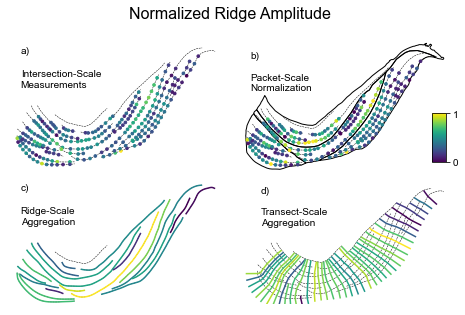

In [17]:
# =========== FIGURE SETUP ===========
rs_variable = "ridge_amp_norm"
rs_variable_title = "Ridge Amplitude"

# Make plot
fig, axs = plt.subplots(2, 2, figsize=(6.5, 4.5))

# Set subtitle loc
text_coords = (839100, 4311350)
label_coords = (839100, 4311650)
# ====================================



# Regular ITX plot
itx.plot(ax=axs[0, 0], column=rs_variable, markersize=7)
ridges.plot(ax=axs[0, 0], color="k", ls="--", lw=0.5, zorder=0)

axs[0,0].text(*text_coords, "Intersection-Scale\nMeasurements", size=10)
axs[0,0].set_axis_off()
axs[0,0].text(*label_coords, "a)", size=10)


# Packet Plot
# divider = make_axes_locatable(axs[0, 1])
# cax = divider.append_axes("right", size="5%", pad=0.1, aspect=10)

packet_norm.plot(ax=axs[0,1], column=rs_variable, markersize=7) #, legend=True, cax=cax)
ridges.plot(ax=axs[0,1], color="k", ls="--", lw=0.5, zorder=0)
packets.boundary.plot(ax=axs[0,1], color="k", lw=1, zorder=0)

# min_max = [1,0]
# cax.set_yticks(min_max, labels = np.round(min_max, 1), size=8)
# cax.set_ylabel("Normalized Amplitude", rotation=270, size=8)

axs[0,1].text(*text_coords, "Packet-Scale\nNormalization", size=10)
axs[0,1].set_axis_off()
axs[0,1].text(*label_coords, "b)", size=10)


# Ridge plot
ridge_agg.plot(ax=axs[1,0], column=rs_variable)
ridges.plot(ax=axs[1,0], color="k", ls="--", lw=0.5, zorder=0)

axs[1,0].text(*text_coords, "Ridge-Scale\nAggregation", size=10)
axs[1,0].set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))
axs[1,0].set_axis_off()
axs[1,0].text(*label_coords, "c)", size=10)


# Transect Plot
trans_agg.plot(ax=axs[1,1], column=rs_variable, linewidth=1.5)
ridges.plot(ax=axs[1,1], color="k", ls="--", lw=0.5, zorder=0)

axs[1,1].text(*text_coords, "Transect-Scale\nAggregation", size=10)
axs[1,1].set_axis_off()
axs[1,1].set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))
axs[1,1].text(*label_coords, "d)", size=10)


# Colorbar
cax = plt.axes((0.93, 0.5, 0.03, 0.15))
cbar = fig.colorbar(cm.ScalarMappable(cmap="viridis"), cax=cax)
cbar.set_ticks([0, 1])

plt.suptitle(f"Normalized {rs_variable_title}", size=16)
plt.tight_layout()


plt.savefig(f"figures/MultiScaleMetrics_{bend_id}_{rs_variable}_2by2.png", dpi=300)

### Width

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/1541160289.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


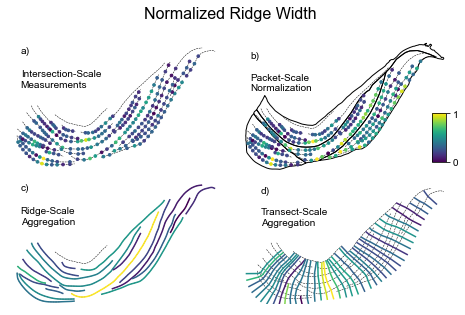

In [18]:
# =========== FIGURE SETUP ===========
rs_variable = "ridge_width_norm"
rs_variable_title = "Ridge Width"

# Make plot
fig, axs = plt.subplots(2, 2, figsize=(6.5, 4.5))

# Set subtitle loc
text_coords = (839100, 4311350)
label_coords = (839100, 4311650)
# ====================================



# Regular ITX plot
itx.plot(ax=axs[0, 0], column=rs_variable, markersize=7)
ridges.plot(ax=axs[0, 0], color="k", ls="--", lw=0.5, zorder=0)

axs[0,0].text(*text_coords, "Intersection-Scale\nMeasurements", size=10)
axs[0,0].set_axis_off()
axs[0,0].text(*label_coords, "a)", size=10)


# Packet Plot
# divider = make_axes_locatable(axs[0, 1])
# cax = divider.append_axes("right", size="5%", pad=0.1, aspect=10)

packet_norm.plot(ax=axs[0,1], column=rs_variable, markersize=7) #, legend=True, cax=cax)
ridges.plot(ax=axs[0,1], color="k", ls="--", lw=0.5, zorder=0)
packets.boundary.plot(ax=axs[0,1], color="k", lw=1, zorder=0)

# min_max = [1,0]
# cax.set_yticks(min_max, labels = np.round(min_max, 1), size=8)
# cax.set_ylabel("Normalized Amplitude", rotation=270, size=8)

axs[0,1].text(*text_coords, "Packet-Scale\nNormalization", size=10)
axs[0,1].set_axis_off()
axs[0,1].text(*label_coords, "b)", size=10)


# Ridge plot
ridge_agg.plot(ax=axs[1,0], column=rs_variable)
ridges.plot(ax=axs[1,0], color="k", ls="--", lw=0.5, zorder=0)

axs[1,0].text(*text_coords, "Ridge-Scale\nAggregation", size=10)
axs[1,0].set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))
axs[1,0].set_axis_off()
axs[1,0].text(*label_coords, "c)", size=10)


# Transect Plot
trans_agg.plot(ax=axs[1,1], column=rs_variable, linewidth=1.5)
ridges.plot(ax=axs[1,1], color="k", ls="--", lw=0.5, zorder=0)

axs[1,1].text(*text_coords, "Transect-Scale\nAggregation", size=10)
axs[1,1].set_axis_off()
axs[1,1].set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))
axs[1,1].text(*label_coords, "d)", size=10)


# Colorbar
cax = plt.axes((0.93, 0.5, 0.03, 0.15))
cbar = fig.colorbar(cm.ScalarMappable(cmap="viridis"), cax=cax)
cbar.set_ticks([0, 1])

plt.suptitle(f"Normalized {rs_variable_title}", size=16)
plt.tight_layout()


plt.savefig(f"figures/MultiScaleMetrics_{bend_id}_{rs_variable}_2by2.png", dpi=300)

### Migration Distance

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/3582456779.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


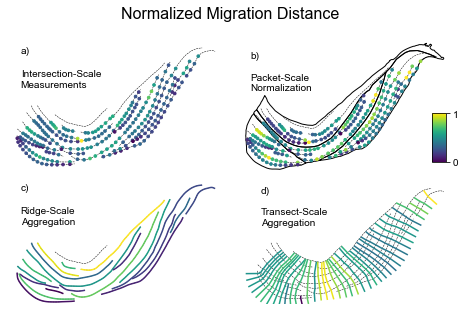

In [19]:
# =========== FIGURE SETUP ===========
rs_variable = "pre_mig_dist_norm"
rs_variable_title = "Migration Distance"

# Make plot
fig, axs = plt.subplots(2, 2, figsize=(6.5, 4.5))

# Set subtitle loc
text_coords = (839100, 4311350)
label_coords = (839100, 4311650)
# ====================================



# Regular ITX plot
itx.plot(ax=axs[0, 0], column=rs_variable, markersize=7)
ridges.plot(ax=axs[0, 0], color="k", ls="--", lw=0.5, zorder=0)

axs[0,0].text(*text_coords, "Intersection-Scale\nMeasurements", size=10)
axs[0,0].set_axis_off()
axs[0,0].text(*label_coords, "a)", size=10)


# Packet Plot
# divider = make_axes_locatable(axs[0, 1])
# cax = divider.append_axes("right", size="5%", pad=0.1, aspect=10)

packet_norm.plot(ax=axs[0,1], column=rs_variable, markersize=7) #, legend=True, cax=cax)
ridges.plot(ax=axs[0,1], color="k", ls="--", lw=0.5, zorder=0)
packets.boundary.plot(ax=axs[0,1], color="k", lw=1, zorder=0)

# min_max = [1,0]
# cax.set_yticks(min_max, labels = np.round(min_max, 1), size=8)
# cax.set_ylabel("Normalized Amplitude", rotation=270, size=8)

axs[0,1].text(*text_coords, "Packet-Scale\nNormalization", size=10)
axs[0,1].set_axis_off()
axs[0,1].text(*label_coords, "b)", size=10)


# Ridge plot
ridge_agg.plot(ax=axs[1,0], column=rs_variable)
ridges.plot(ax=axs[1,0], color="k", ls="--", lw=0.5, zorder=0)

axs[1,0].text(*text_coords, "Ridge-Scale\nAggregation", size=10)
axs[1,0].set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))
axs[1,0].set_axis_off()
axs[1,0].text(*label_coords, "c)", size=10)


# Transect Plot
trans_agg.plot(ax=axs[1,1], column=rs_variable, linewidth=1.5)
ridges.plot(ax=axs[1,1], color="k", ls="--", lw=0.5, zorder=0)

axs[1,1].text(*text_coords, "Transect-Scale\nAggregation", size=10)
axs[1,1].set_axis_off()
axs[1,1].set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))
axs[1,1].text(*label_coords, "d)", size=10)


# Colorbar
cax = plt.axes((0.93, 0.5, 0.03, 0.15))
cbar = fig.colorbar(cm.ScalarMappable(cmap="viridis"), cax=cax)
cbar.set_ticks([0, 1])

plt.suptitle(f"Normalized {rs_variable_title}", size=16)
plt.tight_layout()


plt.savefig(f"figures/MultiScaleMetrics_{bend_id}_{rs_variable}_2by2.png", dpi=300)

In [20]:
itx.xs("r_022", level=1).pre_mig_dist.median()

78.45661183554719

In [21]:
dist_itx = itx[[col for col in itx.columns if "mig_dist" in col]+["geometry"]]
dist_itx

pre_mig_dist  post_mig_dist  pre_mig_dist_norm  \
transect_id ridge_id                                                   
t_009       r_002        86.849140      61.506965           0.622325   
            r_003        55.468343      86.849140           0.371423   
            r_007        47.243526      55.468343           0.305662   
            r_018         9.490952      20.154985           0.003815   
            r_019        20.154985     114.298928           0.089079   
...                            ...            ...                ...   
t_047       r_012        81.149474      39.219145           0.576754   
            r_013        39.219145      85.960167           0.241504   
t_048       r_012        65.307459      47.815527           0.450091   
            r_013        47.815527      90.779112           0.310236   
t_049       r_013        69.967953     116.768125           0.487353   

                                            geometry  
transect_id ridge_id                                  
t_009       r_002     POINT (839158.987 4310982.258)  
            r_003     POINT (839220.219 4311043.849)  
            r_007     POINT (839260.583 4311081.895)  
            r_018     POINT (839089.497 4310894.231)  
            r_019     POINT (839069.856 4310889.707)  
...                                              ...  
t_047       r_012     POINT (840584.810 4311519.878)  
            r_013     POINT (840619.250 4311501.117)  
t_048       r_012     POINT (840610.338 4311576.848)  
            r_013     POINT (840653.594 4311556.471)  
t_049       r_013     POINT (840687.903 4311623.684)  

[245 rows x 4 columns]

In [22]:
trans_amp_range = trans_agg["ridge_amp"].max() - trans_agg["ridge_amp"].min()
ridge_amp_range = ridge_agg["ridge_amp"].max() - ridge_agg["ridge_amp"].min()

trans_width_range = trans_agg["ridge_width"].max() - trans_agg["ridge_width"].min()
ridge_width_range = ridge_agg["ridge_width"].max() - ridge_agg["ridge_width"].min()

print(f"Range for transect median amplitude: {trans_amp_range}")
print(f"Range for ridge median amplitude: {ridge_amp_range}")
print("\n")
print(f"Range for transect median width: {trans_width_range}")
print(f"Range for ridge median amplitude: {ridge_width_range}")

Range for transect median amplitude: 1.3851680755615234
Range for ridge median amplitude: 1.4942941665649414


Range for transect median width: 26.0
Range for ridge median amplitude: 19.5


Text(443.16683310346167, 0.5, 'Ridge Amplitude [m]')

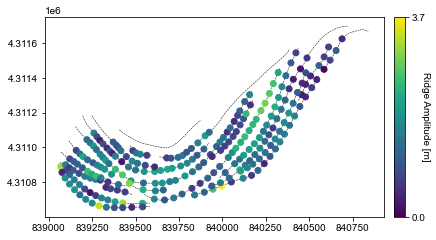

In [23]:
fig, ax = plt.subplots(1,1, figsize=(6.5, 4))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, aspect=5)

vmin = 0
vmax = itx["ridge_amp"].max()

itx.plot(ax=ax, column="ridge_amp", legend=True, cax=cax, vmin=vmin)
ridges.plot(ax=ax, color="k", ls="--", lw=0.5, zorder=0)
# packets.boundary.plot(ax=ax3, color="k", lw=1, zorder=0)

min_max = [vmin, vmax]
cax.set_yticks(min_max, labels = np.round(min_max, 1))
cax.set_ylabel("Ridge Amplitude [m]", rotation=270)

# ax.set_axis_off()


In [24]:
def calc_iqr(x):
    q25, q75 = np.quantile(x, [0.25, 0.75])
    iqr = q75 - q25
    return iqr

(array([3., 1., 3., 9., 6., 8., 5., 2., 2., 2.]),
 array([0.        , 0.12995577, 0.25991154, 0.38986731, 0.51982307,
        0.64977884, 0.77973461, 0.90969038, 1.03964615, 1.16960192,
        1.29955769]),
 <BarContainer object of 10 artists>)

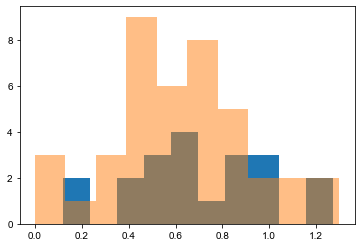

In [25]:
ridge_iqr = ridge_metrics["ridge_amp"].groupby(level=-1).apply(calc_iqr)
trans_iqr = ridge_metrics["ridge_amp"].groupby(level=0).apply(calc_iqr)

fig, ax = plt.subplots(1, 1)

ax.hist(ridge_iqr.values)
ax.hist(trans_iqr.values, alpha=0.5)

In [26]:
mx = itx["ridge_amp"].max()
mn = itx["ridge_amp"].min()


# Boxplot + Histogram
Make a supplemental figure to the ridge metric maps above.  
This figure will contain boxplots of the ridge and transect distributions with a histogram right beside

In [27]:
def get_boxplot_vals(df):
    """Get the x,y values of the graphic elements of a pandas boxplot"""

    box_dict = df.boxplot(return_type="dict")
    
    # Need to clear the plt axis generated by the .boxplot() call above
    # For some reason, a plt axis is still generated when return_type is set to dict
    plt.cla()
    
    data = {
        "transect_id" : df.columns.values,
        "upper" : [i.get_ydata()[1] for i in box_dict["whiskers"][1::2]],
        "q3" : [i.get_ydata()[0] for i in box_dict["whiskers"][1::2]],
        "med" : [i.get_ydata()[0] for i in box_dict["medians"]],
        "q1" : [i.get_ydata()[0] for i in box_dict["whiskers"][::2]],
        "lower" : [i.get_ydata()[1] for i in box_dict["whiskers"][::2]]
    }

    f_x = [x.get_xdata()[0] for x in box_dict["fliers"] if x.get_xdata().size > 0]
    f_y = [y.get_ydata()[0] for y in box_dict["fliers"] if y.get_xdata().size > 0]
    fliers = [f_x, f_y]

    out_df = pd.DataFrame.from_dict(data).set_index("transect_id")

    return (out_df, fliers)

In [28]:
ordered_ridge_nums = {
    "p_04" : ["r_019", "r_018", "r_001", "r_020", "r_021", "r_002"],
    "p_03" : ["r_013", "r_010", "r_012", "r_017", "r_016", "r_009"],
    "p_02" : ["r_006", "r_005", "r_004", "r_003"],
    "p_01" : ["r_007", "r_023", "r_008", "r_015"]
}

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/2368947111.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i if i in short_tlabels[::5] else "" for i in short_tlabels], size=8)
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/2368947111.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(short_rlabels, rotation=90, size=8)
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/2368947111.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(short_rlabels, rotation=90, size=8)
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/2368947111.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(short_rlabels, rotation=90, size=8)
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/2368947111.py:69: MatplotlibDeprecationW

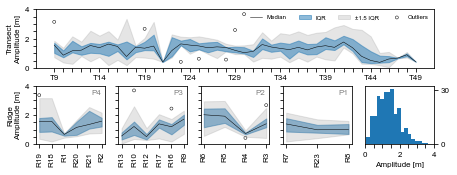

In [29]:

# =========== FIGURE SETUP ===========
rs_variable = "ridge_amp"
rs_variable_title = "Amplitude"
rs_variable_fn = "amplitude"

var_lim = (0, 4)
step = 0.5

fig = plt.figure(figsize=(6.5, 2.5))
gs = GridSpec(2, 5, hspace=0.3)
# ====================================

# Transects
ax = fig.add_subplot(gs[0, 0:])

# Arrange data so that each column contains the measurements for a transect
t = ridge_metrics.unstack(level=0)[rs_variable]

# Get the spread series data (whiskers, q1, med, q3) plus the outliers (fliers) from plt.boxplot dict
df, fliers = get_boxplot_vals(t)

# Plot the spread as a series
ax.plot(df["med"], color="k", lw=0.5, zorder=4, label = "Median")
ax.fill_between(range(len(df)), df["q3"], df["q1"], alpha=0.5, color="tab:blue", zorder=3, label = "IQR")
ax.fill_between(range(len(df)), df["upper"], df["lower"], alpha=0.2, color="grey", zorder=2, label ="±1.5 IQR")
ax.scatter(np.array(fliers[0])-1, fliers[1], marker=".", lw=0.5, color="none", edgecolors="k", label="Outliers")

# Shorten xtick labels
short_tlabels = ridge_metrics.index.levels[0].str.replace("t_0*", "T", regex=True)
ax.set_xticklabels([i if i in short_tlabels[::5] else "" for i in short_tlabels], size=8)

# Set yaxis
ax.set_ylabel(f"Transect\n{rs_variable_title} [m]", size=8)
ax.set_ylim(*var_lim)

# Adjust ytick frequency according to `step`
yticks = np.arange(var_lim[0], var_lim[1]+step, step)
ax.set_yticks(yticks)

# Only label the first, middle, and last ytick
ax.set_yticklabels(labels=[int(i) if i in [var_lim[0], var_lim[1]/2, var_lim[1]] else "" for i in yticks], size=8)

ax.legend(fontsize=6, ncol=4, frameon=False, loc="upper right")

# Ridges

# Group ridge metrics by packet ID
packet_dfs = ridge_metrics_w_packets.unstack(level=1)[rs_variable].groupby("packet_id")

# Drop columns with all nans (ridges outside of packets)
packet_dfs = [(p_num, df.dropna(axis=1, how="all")) for p_num, df in packet_dfs]

# Sort packets by ascending distance from channel
packet_dfs = sorted(packet_dfs, key=lambda x: x[0], reverse=True)

for i, (p_num, packet_df) in enumerate(packet_dfs):

    ax = fig.add_subplot(gs[1, i])

    # Get the spread series data (whiskers, q1, med, q3) plus the outliers (fliers) from plt.boxplot dict
    packet_df = packet_df[[i for i in ordered_ridge_nums[p_num] if i in packet_df.columns]]
    df, fliers = get_boxplot_vals(packet_df)
    df = df.reindex(ordered_ridge_nums[p_num])

    # Plot the spread as a series
    ax.plot(df["med"], color="k", lw=0.5, zorder=3)
    ax.fill_between(range(len(df)), df["q3"], df["q1"], alpha=0.5, color="tab:blue", zorder=2)
    ax.fill_between(range(len(df)), df["upper"], df["lower"], alpha=0.2, color="grey", zorder=2)
    ax.scatter(np.array(fliers[0])-1, fliers[1], marker=".", lw=0.5, color="none", edgecolors="k")

    # Label the plot with packet number
    ax.annotate(f"P{p_num[-1]}", (0.8, 0.85), xycoords="axes fraction", 
                color="grey", size=8)

    # Format xticks
    short_rlabels = packet_df.columns.str.replace("r_0*", "R", regex=True)
    ax.set_xticklabels(short_rlabels, rotation=90, size=8)

    # Format yticks
    ax.set_ylim(*var_lim)
    yticks = np.arange(var_lim[0], var_lim[1]+step, step)
    ax.set_yticks(yticks)
    if i == 0:
        ax.set_yticklabels(labels=[int(i) if i in [var_lim[0], var_lim[1]/2, var_lim[1]] else "" for i in yticks], size=8)
        ax.set_ylabel(f"Ridge\n{rs_variable_title} [m]", size=8)
    else:
        ax.set_yticklabels([])


# Histogram
ax = fig.add_subplot(gs[1, 4])
ridge_metrics[rs_variable].hist(ax=ax, bins=18, grid=False)
ax.set_xlim(*var_lim)
ax.set_xlabel(f"{rs_variable_title} [m]", size=8)

xticks = np.arange(var_lim[0], var_lim[1]+step, step)
ax.set_xticks(xticks)
ax.set_xticklabels(labels=[int(i) if i in [var_lim[0], var_lim[1]/2, var_lim[1]] else "" for i in yticks], size=8)
ax.yaxis.tick_right()
ax.set_yticks([0, 30])
ax.set_yticklabels([0, 30], size=8)

plt.subplots_adjust(top=0.95, bottom=0.2, left=0.1, right=0.95)
plt.savefig(f"figures/spread_series_hist_combo_{rs_variable_fn}.png", dpi=300)


/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/3954066614.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i if i in short_tlabels[::5] else "" for i in short_tlabels], size=8)
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/3954066614.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(short_rlabels, rotation=90, size=8)
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/3954066614.py:72: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.scatter(np.array(fliers[0])-1, fliers[1], marker=".", lw=0.5, color="none", edgecolors="k")
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/3954066614.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.

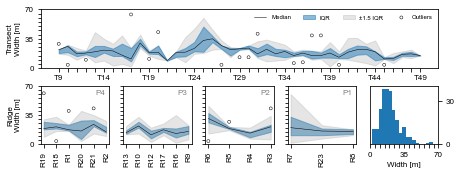

In [30]:
# =========== FIGURE SETUP ===========
rs_variable = "ridge_width"
rs_variable_title = "Width"
rs_variable_fn = "width"

var_lim = (0,70) # plot limits for the variable
step = 5

fig = plt.figure(figsize=(6.5, 2.5))
gs = GridSpec(2, 5, hspace=0.3)


# ====================================


# Transects
ax = fig.add_subplot(gs[0, 0:])

# Arrange data so that each column contains the measurements for a transect
t = ridge_metrics.unstack(level=0)[rs_variable]

# Get the spread series data (whiskers, q1, med, q3) plus the outliers (fliers) from plt.boxplot dict
df, fliers = get_boxplot_vals(t)

# Plot the spread as a series
ax.plot(df["med"], color="k", lw=0.5, zorder=4, label = "Median")
ax.fill_between(range(len(df)), df["q3"], df["q1"], alpha=0.5, color="tab:blue", zorder=3, label = "IQR")
ax.fill_between(range(len(df)), df["upper"], df["lower"], alpha=0.2, color="grey", zorder=2, label ="±1.5 IQR")
ax.scatter(np.array(fliers[0])-1, fliers[1], marker=".", lw=0.5, color="none", edgecolors="k", label="Outliers")

# Shorten xtick labels
short_tlabels = ridge_metrics.index.levels[0].str.replace("t_0*", "T", regex=True)
ax.set_xticklabels([i if i in short_tlabels[::5] else "" for i in short_tlabels], size=8)

# Set yaxis
ax.set_ylabel(f"Transect\n{rs_variable_title} [m]", size=8)
ax.set_ylim(*var_lim)

# Adjust ytick frequency according to `step`
yticks = np.arange(var_lim[0], var_lim[1]+step, step)
ax.set_yticks(yticks)

# Only label the first, middle, and last ytick
ax.set_yticklabels(labels=[int(i) if i in [var_lim[0], var_lim[1]/2, var_lim[1]] else "" for i in yticks], size=8)

ax.legend(fontsize=6, ncol=4, frameon=False, loc="upper right")

# Ridges

# Group ridge metrics by packet ID
packet_dfs = ridge_metrics_w_packets.unstack(level=1)[rs_variable].groupby("packet_id")

# Drop columns with all nans (ridges outside of packets)
packet_dfs = [(p_num, df.dropna(axis=1, how="all")) for p_num, df in packet_dfs]

# Sort packets by ascending distance from channel
packet_dfs = sorted(packet_dfs, key=lambda x: x[0], reverse=True)

for i, (p_num, packet_df) in enumerate(packet_dfs):

    ax = fig.add_subplot(gs[1, i])

    # Get the spread series data (whiskers, q1, med, q3) plus the outliers (fliers) from plt.boxplot dict
    packet_df = packet_df[[i for i in ordered_ridge_nums[p_num] if i in packet_df.columns]]
    df, fliers = get_boxplot_vals(packet_df)
    df = df.reindex(ordered_ridge_nums[p_num])

    # Plot the spread as a series
    ax.plot(df["med"], color="k", lw=0.5, zorder=3)
    ax.fill_between(range(len(df)), df["q3"], df["q1"], alpha=0.5, color="tab:blue", zorder=2)
    ax.fill_between(range(len(df)), df["upper"], df["lower"], alpha=0.2, color="grey", zorder=2)
    ax.scatter(np.array(fliers[0])-1, fliers[1], marker=".", lw=0.5, color="none", edgecolors="k")

    # Label the plot with packet number
    ax.annotate(f"P{p_num[-1]}", (0.8, 0.85), xycoords="axes fraction", 
                color="grey", size=8)

    # Format xticks
    short_rlabels = packet_df.columns.str.replace("r_0*", "R", regex=True)
    ax.set_xticklabels(short_rlabels, rotation=90, size=8)

    # Format yticks
    ax.set_ylim(*var_lim)
    yticks = np.arange(var_lim[0], var_lim[1]+step, step)
    ax.set_yticks(yticks)
    if i == 0:
        ax.set_yticklabels(labels=[int(i) if i in [var_lim[0], var_lim[1]/2, var_lim[1]] else "" for i in yticks], size=8)
        ax.set_ylabel(f"Ridge\n{rs_variable_title} [m]", size=8)
    else:
        ax.set_yticklabels([])


# Histogram
ax = fig.add_subplot(gs[1, 4])
ridge_metrics[rs_variable].hist(ax=ax, bins=18, grid=False)
ax.set_xlim(*var_lim)
ax.set_xlabel(f"{rs_variable_title} [m]", size=8)

xticks = np.arange(var_lim[0], var_lim[1]+step, step)
ax.set_xticks(xticks)
ax.set_xticklabels(labels=[int(i) if i in [var_lim[0], var_lim[1]/2, var_lim[1]] else "" for i in yticks], size=8)
ax.yaxis.tick_right()
ax.set_yticks([0, 30])
ax.set_yticklabels([0, 30], size=8)

plt.subplots_adjust(top=0.95, bottom=0.2, left=0.1, right=0.95)
plt.savefig(f"figures/spread_series_hist_combo_{rs_variable_fn}.png", dpi=300)

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/2603561042.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i if i in short_tlabels[::5] else "" for i in short_tlabels], size=8)
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/2603561042.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(short_rlabels, rotation=90, size=8)
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/2603561042.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(short_rlabels, rotation=90, size=8)
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/2603561042.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(short_rlabels, rotation=90, size=8)
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_85765/2603561042.py:80: UserWarning: FixedForm

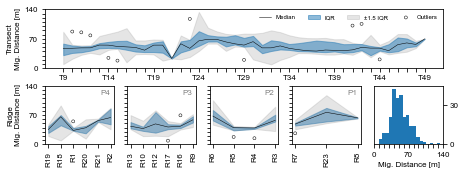

In [31]:
# =========== FIGURE SETUP ===========
rs_variable = "pre_mig_dist"
rs_variable_title = "Mig. Distance"
rs_variable_fn = "migdist"

var_lim = (0,140) # plot limits for the variable
step = 10

fig = plt.figure(figsize=(6.5, 2.5))
gs = GridSpec(2, 5, hspace=0.3)


# ====================================


# Transects
ax = fig.add_subplot(gs[0, 0:])

# Arrange data so that each column contains the measurements for a transect
t = ridge_metrics.unstack(level=0)[rs_variable]

# Get the spread series data (whiskers, q1, med, q3) plus the outliers (fliers) from plt.boxplot dict
df, fliers = get_boxplot_vals(t)

# Plot the spread as a series
ax.plot(df["med"], color="k", lw=0.5, zorder=4, label = "Median")
ax.fill_between(range(len(df)), df["q3"], df["q1"], alpha=0.5, color="tab:blue", zorder=3, label = "IQR")
ax.fill_between(range(len(df)), df["upper"], df["lower"], alpha=0.2, color="grey", zorder=2, label ="±1.5 IQR")
ax.scatter(np.array(fliers[0])-1, fliers[1], marker=".", lw=0.5, color="none", edgecolors="k", label="Outliers")

# Shorten xtick labels
short_tlabels = ridge_metrics.index.levels[0].str.replace("t_0*", "T", regex=True)
ax.set_xticklabels([i if i in short_tlabels[::5] else "" for i in short_tlabels], size=8)

# Set yaxis
ax.set_ylabel(f"Transect\n{rs_variable_title} [m]", size=8)
ax.set_ylim(*var_lim)

# Adjust ytick frequency according to `step`
yticks = np.arange(var_lim[0], var_lim[1]+step, step)
ax.set_yticks(yticks)

# Only label the first, middle, and last ytick
ax.set_yticklabels(labels=[int(i) if i in [var_lim[0], var_lim[1]/2, var_lim[1]] else "" for i in yticks], size=8)

ax.legend(fontsize=6, ncol=4, frameon=False, loc="upper right")


# Ridges
# Group ridge metrics by packet ID
packet_dfs = ridge_metrics_w_packets.unstack(level=1)[rs_variable].groupby("packet_id")

# Drop columns with all nans (ridges outside of packets)
packet_dfs = [(p_num, df.dropna(axis=1, how="all")) for p_num, df in packet_dfs]

# Sort packets by ascending distance from channel
packet_dfs = sorted(packet_dfs, key=lambda x: x[0], reverse=True)

for i, (p_num, packet_df) in enumerate(packet_dfs):

    ax = fig.add_subplot(gs[1, i])

    # Get the spread series data (whiskers, q1, med, q3) plus the outliers (fliers) from plt.boxplot dict
    packet_df = packet_df[[i for i in ordered_ridge_nums[p_num] if i in packet_df.columns]]
    df, fliers = get_boxplot_vals(packet_df)
    df = df.reindex(ordered_ridge_nums[p_num])

    # Plot the spread as a series
    ax.plot(df["med"], color="k", lw=0.5, zorder=3)
    ax.fill_between(range(len(df)), df["q3"], df["q1"], alpha=0.5, color="tab:blue", zorder=2)
    ax.fill_between(range(len(df)), df["upper"], df["lower"], alpha=0.2, color="grey", zorder=2)
    ax.scatter(np.array(fliers[0])-1, fliers[1], marker=".", lw=0.5, color="none", edgecolors="k")

    # Label the plot with packet number
    ax.annotate(f"P{p_num[-1]}", (0.8, 0.85), xycoords="axes fraction", 
                color="grey", size=8)

    # Format xticks
    short_rlabels = packet_df.columns.str.replace("r_0*", "R", regex=True)
    ax.set_xticklabels(short_rlabels, rotation=90, size=8)

    # Format yticks
    ax.set_ylim(*var_lim)
    yticks = np.arange(var_lim[0], var_lim[1]+step, step)
    ax.set_yticks(yticks)
    if i == 0:
        ax.set_yticklabels(labels=[int(i) if i in [var_lim[0], var_lim[1]/2, var_lim[1]] else "" for i in yticks], size=8)
        ax.set_ylabel(f"Ridge\n{rs_variable_title} [m]", size=8)
    else:
        ax.set_yticklabels([])


# Histogram
ax = fig.add_subplot(gs[1, 4])
ridge_metrics[rs_variable].hist(ax=ax, bins=18, grid=False)
ax.set_xlim(*var_lim)
ax.set_xlabel(f"{rs_variable_title} [m]", size=8)

xticks = np.arange(var_lim[0], var_lim[1]+step, step)
ax.set_xticks(xticks)
ax.set_xticklabels(labels=[int(i) if i in [var_lim[0], var_lim[1]/2, var_lim[1]] else "" for i in yticks], size=8)
ax.yaxis.tick_right()
ax.set_yticks([0, 30])
ax.set_yticklabels([0, 30], size=8)

plt.subplots_adjust(top=0.95, bottom=0.2, left=0.1, right=0.95)
plt.savefig(f"figures/spread_series_hist_combo_{rs_variable_fn}.png", dpi=300)

In [32]:
def get_boxplot_vals(df):
    """Get the x,y values of the graphic elements of a pandas boxplot"""

    box_dict = df.boxplot(return_type="dict")

    data = {
        "transect_id" : df.columns.values,
        "upper" : [i.get_ydata()[1] for i in box_dict["whiskers"][1::2]],
        "q3" : [i.get_ydata()[0] for i in box_dict["whiskers"][1::2]],
        "med" : [i.get_ydata()[0] for i in box_dict["medians"]],
        "q1" : [i.get_ydata()[0] for i in box_dict["whiskers"][::2]],
        "lower" : [i.get_ydata()[1] for i in box_dict["whiskers"][::2]]
    }

    f_x = [x.get_xdata()[0] for x in box_dict["fliers"] if x.get_xdata().size > 0]
    f_y = [y.get_ydata()[0] for y in box_dict["fliers"] if y.get_xdata().size > 0]
    fliers = [f_x, f_y]

    out_df = pd.DataFrame.from_dict(data).set_index("transect_id")

    return (out_df, fliers)

Text(0.5, 0, 'Ridge Width [m]')

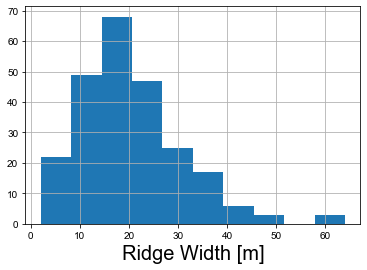

In [33]:
ax = ridge_metrics["ridge_width"].hist()
ax.set_xlabel("Ridge Width [m]", size=20)

# Plot Archive

In [34]:
# 3x1 plot

# def adjust_ax_lim(min, max, perc):
#     dist = max - min
#     buff = dist*perc
#     return(min-buff, max+buff)

# rs_variable = "ridge_amp_norm"

# # Make plot
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6.5, 2))

# # text_coords = (839355, 4311246)
# text_coords = (839000, 4311350)

# # Ridge plot
# ridge_agg.plot(ax=ax1, column=rs_variable)  #, linewidth=ridge_agg["ridge_width"]/12)
# ridges.plot(ax=ax1, color="k", ls="--", lw=0.5, zorder=0)

# ax1.text(*text_coords, "Ridge-Scale\nAggregation", size=10)
# # ax1.set_title("Ridge-Scale Aggregation")
# ax1.set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))
# ax1.set_axis_off()

# # Transect Plot
# trans_agg.plot(ax=ax2, column=rs_variable, linewidth=1.5)
# ridges.plot(ax=ax2, color="k", ls="--", lw=0.5, zorder=0)

# ax2.text(*text_coords, "Transect-Scale\nAggregation", size=10)
# # ax2.set_title("Transect-Scale Aggregation")
# ax2.set_axis_off()
# ax2.set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))

# # Packet Plot
# divider = make_axes_locatable(ax3)
# cax = divider.append_axes("right", size="5%", pad=0.1, aspect=10)

# # packet_norm.plot(ax=ax3, column="ridge_amp", markersize=packet_norm["ridge_width"]*8, legend=True, cax=cax)
# packet_norm.plot(ax=ax3, column=rs_variable, markersize=3, legend=True, cax=cax)
# ridges.plot(ax=ax3, color="k", ls="--", lw=0.5, zorder=0)
# packets.boundary.plot(ax=ax3, color="k", lw=1, zorder=0)

# min_max = [0,1]
# cax.set_yticks(min_max, labels = np.round(min_max, 1), size=8)
# cax.set_ylabel("Norm Amp", rotation=270, size=8)

# ax3.text(*text_coords, "Packet-Scale\nNormalization", size=10)
# # ax3.set_title("Packet-Scale Normalization")
# ax3.set_axis_off()
# ax3.set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))

# # plt.suptitle("Aggregated Ridge Metrics", size=20)
# plt.tight_layout()


# # plt.savefig(f"MultiScaleMetrics_{bend_id}.png", dpi=300)

In [35]:
# Original 2x2 plot

# def adjust_ax_lim(min, max, perc):
#     dist = max - min
#     buff = dist*perc
#     return(min-buff, max+buff)

# # Make plot
# fig, axs = plt.subplots(2, 2, figsize=(6.5, 4.5))

# # text_coords = (839355, 4311246)
# text_coords = (839100, 4311350)



# # Regular ITX plot
# divider = make_axes_locatable(axs[0, 0])
# cax = divider.append_axes("right", size="5%", pad=0.1, aspect=4)

# vmin = 0
# vmax = itx["ridge_amp"].max()

# itx.plot(ax=axs[0, 0], column="ridge_amp", markersize=7, legend=True, cax=cax, vmin=vmin)
# ridges.plot(ax=axs[0, 0], color="k", ls="--", lw=0.5, zorder=0)
# # packets.boundary.plot(ax=axs[1,0], color="k", lw=1, zorder=0)

# min_max = [vmin, vmax]
# cax.set_yticks(min_max, labels = np.round(min_max, 1), size=8)
# cax.set_ylabel("Ridge Amplitude [m]", rotation=270, size=8)

# axs[0, 0].text(*text_coords, "Intersection-Scale\nMeasurements", size=10)
# axs[0, 0].set_axis_off()

# # Packet Plot
# divider = make_axes_locatable(axs[0, 1])
# cax = divider.append_axes("right", size="5%", pad=0.1, aspect=10)

# # packet_norm.plot(ax=axs[1,0], column="ridge_amp", markersize=packet_norm["ridge_width"]*8, legend=True, cax=cax)
# packet_norm.plot(ax=axs[0, 1], column="ridge_amp", markersize=7, legend=True, cax=cax)
# ridges.plot(ax=axs[0, 1], color="k", ls="--", lw=0.5, zorder=0)
# packets.boundary.plot(ax=axs[0, 1], color="k", lw=1, zorder=0)

# min_max = [0,1]
# cax.set_yticks(min_max, labels = np.round(min_max, 1), size=8)
# cax.set_ylabel("Normalized Amplitude", rotation=270, size=8)

# axs[0, 1].text(*text_coords, "Packet-Scale\nNormalization", size=10)
# # axs[1,0].set_title("Packet-Scale Normalization")
# axs[0, 1].set_axis_off()
# # axs[0, 1].set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))


# # Ridge plot
# ridge_agg.plot(ax=axs[1,0], column="ridge_amp_norm", linewidth=ridge_agg["ridge_width"]/12)
# ridges.plot(ax=axs[1,0], color="k", ls="--", lw=0.5, zorder=0)

# axs[1,0].text(*text_coords, "Ridge-Scale\nAggregation", size=10)
# # axs[0, 0].set_title("Ridge-Scale Aggregation")
# axs[1,0].set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))
# axs[1,0].set_axis_off()

# # Transect Plot
# trans_agg.plot(ax=axs[1,1], column="ridge_amp_norm", linewidth=1.5)
# ridges.plot(ax=axs[1,1], color="k", ls="--", lw=0.5, zorder=0)

# axs[1,1].text(*text_coords, "Transect-Scale\nAggregation", size=10)
# # axs[0, 1].set_title("Transect-Scale Aggregation")
# axs[1,1].set_axis_off()
# axs[1,1].set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))



# # plt.suptitle("Aggregated Ridge Metrics", size=20)
# plt.tight_layout()


# plt.savefig(f"MultiScaleMetrics_{bend_id}_2by2.png", dpi=300)

In [36]:
# # Box plot + histogram combo

# # =========== FIGURE SETUP ===========
# rs_variable = "ridge_amp"
# rs_variable_title = "Amplitude"
# rs_variable_fn = "amplitude"

# var_lim = (0, 4)
# step = 0.5

# fig = plt.figure(figsize=(6.5, 2.5))
# gs = GridSpec(2, 3, hspace=0.3)
# # ====================================


# # Boxplot Props
# boxprops = {"linewidth":0.5, "color":"tab:blue"}
# medianprops = {"linewidth":0.75, "color":"tab:green"}
# whiskerprops = {"linewidth":0.5, "color":"black"}
# capprops = {"linewidth":0.5, "color":"black"}
# flierprops = {"marker":'.', "markersize":3, "markeredgecolor":'black', "markeredgewidth":0.5}

# # Transects
# ax = fig.add_subplot(gs[0, 0:2])
# ridge_metrics.unstack(level=0)[rs_variable].boxplot(ax=ax, grid=False, 
#                                                     boxprops=boxprops, medianprops=medianprops, 
#                                                     whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops)

# short_tlabels = ridge_metrics.index.levels[0].str.replace("t_0*", "T", regex=True)
# ax.set_xticklabels([i if i in short_tlabels[::5] else "" for i in short_tlabels], size=8)

# ax.set_ylabel(f"Transect\n{rs_variable_title} [m]", size=8)
# ax.set_ylim(*var_lim)
# yticks = np.arange(var_lim[0], var_lim[1]+step, step)
# ax.set_yticks(yticks)
# ax.set_yticklabels(labels=[int(i) if i in [var_lim[0], var_lim[1]/2, var_lim[1]] else "" for i in yticks], size=8)

# med_vals = ridge_metrics[rs_variable].groupby("transect_id").median()
# ax.axhspan(med_vals.min(), med_vals.max(), color="tab:green", alpha=0.2, zorder=0)


# # Ridges
# ax = fig.add_subplot(gs[1, 0:2])
# ax = ridge_metrics.unstack(level=1)[rs_variable].boxplot(ax=ax, grid=False,
#                                                          boxprops=boxprops, medianprops=medianprops,
#                                                          whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops)

# short_rlabels = ridge_metrics.index.levels[1].str.replace("r_0*", "R", regex=True)
# ax.set_xticklabels([i if i in short_rlabels[::3] else "" for i in short_rlabels], size=8)

# ax.set_ylabel(f"Ridge\n{rs_variable_title} [m]", size=8)
# ax.set_ylim(*var_lim)
# yticks = np.arange(var_lim[0], var_lim[1]+step, step)
# ax.set_yticks(yticks)
# ax.set_yticklabels(labels=[int(i) if i in [var_lim[0], var_lim[1]/2, var_lim[1]] else "" for i in yticks], size=8)
# med_vals = ridge_metrics[rs_variable].groupby("ridge_id").median()
# ax.axhspan(med_vals.min(), med_vals.max(), color="tab:green", alpha=0.2, zorder=0)

# # Histogram
# ax = fig.add_subplot(gs[:, 2:3])
# ridge_metrics[rs_variable].hist(ax=ax, bins=18, grid=False)
# ax.set_xlim(*var_lim)
# ax.set_xlabel(f"{rs_variable_title} [m]")
# ax.set_xticks(var_lim)
# ax.set_xticklabels(labels=var_lim, size=10)
# # ax.set_title("Amplitude Measurements")
# ax.yaxis.tick_right()
# ax.set_yticks([0, 30])
# ax.set_yticklabels([0, 30], size=10)

# plt.subplots_adjust(top=0.95, bottom=0.2, left=0.08, right=0.95)
# plt.savefig(f"figures/box_hist_combo_{rs_variable_fn}.png", dpi=300)
